In [1]:
import torch
import torch.nn as nn
import torchvision
import numpy as np
import torch.nn.functional as F
import torchvision.transforms as transforms
import pandas as pd
from torch.utils.data import Dataset
import os
from PIL import Image
import sklearn
import sklearn.metrics as sklm
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# If there's a GPU available...
if torch.cuda.is_available():

    # Tell PyTorch to use the GPU.
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla K80


In [3]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
BATCH_SIZE = 32

In [4]:
data_transforms = {
        'train': transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.Resize(224),
            # because scale doesn't always give 224 x 224, this ensures 224 x
            # 224
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
            #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ]),
        'val': transforms.Compose([
            transforms.Resize(224),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
            #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ]),
    }

In [5]:
class CustomDataset(Dataset):

    def __init__(self,path_to_images,labelcsv,transform=None):

        self.transform = transform
        self.path_to_images = path_to_images
        self.df = pd.read_csv(labelcsv)

        self.df = self.df.set_index("Image Index")
        self.PRED_LABEL = [
            'Atelectasis',
            'Cardiomegaly',
            'Effusion',
            'Infiltration',
            'Mass',
            'Nodule',
            'Pneumonia',
            'Pneumothorax',
            'Consolidation',
            'Edema',
            'Emphysema',
            'Fibrosis',
            'Pleural_Thickening',
            'Hernia']

        RESULT_PATH = "results/"

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):

        image = Image.open(
            os.path.join(
                self.path_to_images,
                self.df.index[idx]))
        image = image.convert('RGB')

        label = np.zeros(len(self.PRED_LABEL), dtype=int)
        for i in range(0, len(self.PRED_LABEL)):
            if(self.df[self.PRED_LABEL[i].strip()].iloc[idx].astype('int') > 0):
                label[i] = self.df[self.PRED_LABEL[i].strip()
                                   ].iloc[idx].astype('int')

        if self.transform:
            image = self.transform(image)

        return (image, label,self.df.index[idx])
    
    

In [6]:
def load_data(data_path=None):

    data_train = CustomDataset(
        path_to_images='/home/ubuntu/payload/NIHData/images/',
        labelcsv = 'train_0.1.csv',
        transform=data_transforms['train'])
    data_val = CustomDataset(
        path_to_images='/home/ubuntu/payload/NIHData/images/',
        labelcsv = 'val-small_0.1.csv',
        transform=data_transforms['val'])

    train_loader = torch.utils.data.DataLoader(data_train, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = torch.utils.data.DataLoader(data_val, batch_size=BATCH_SIZE, shuffle=False)

    return train_loader, val_loader , data_train , data_val

In [7]:
def get_cnn_model():

    """
    TODO: Define the CNN model here. 
        We will use the pretrained ResNet18 model, which can be initialized with torchvision.models.resnet18
        Then, replace the last layer (model.fc) with a nn.Linear layer
            The new model.fc should have the same input size but a new output_size of 2
    """

    from torchvision import models

    num_classes = 14
    # your code here
    #raise NotImplementedError
    #old code model = torchvision.models.resnet18()
    model = models.densenet121(pretrained=False)
    #old code num_ftrs = model.fc.in_features
    num_ftrs = model.classifier.in_features
    model.classifier = nn.Sequential(
        nn.Linear(num_ftrs, num_classes), nn.Sigmoid())
    # old code model.fc = nn.Linear(num_ftrs, num_classes)
    #For computation efficiency, we will freeze the weights in the bottom layers
    #If it's too slow, you can turn off layer4's weights update as well
    '''
    for param in model.named_parameters():
        if param[0].split(".")[0] in {'fc', 'layer4'}: continue
        param[1].requires_grad = False'''
    return model

In [8]:
model = get_cnn_model()
model.cuda()
criterion = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
LR = 0.01
optimizer = torch.optim.SGD(
        filter(
            lambda p: p.requires_grad,
            model.parameters()),
        lr=LR,
        momentum=0.9,
        weight_decay=1e-4)

In [9]:
n_epochs = 10
def train_model(model, train_dataloader, val_dataloader, n_epoch=n_epochs, optimizer=optimizer, criterion=criterion):
    import torch.optim as optim
    """
    :param model: A CNN model
    :param train_dataloader: the DataLoader of the training data
    :param n_epoch: number of epochs to train
    :return:
        model: trained model
    TODO:
        Within the loop, do the normal training procedures:
            pass the input through the model
            pass the output through loss_func to compute the loss (name the variable as *loss*)
            zero out currently accumulated gradient, use loss.basckward to backprop the gradients, then call optimizer.step
    """
     # prep model for training
    
    train_epochs_loss = pd.DataFrame(columns=["Epoch No","Loss"])
    val_epochs_loss = pd.DataFrame(columns=["Epoch No","Loss"])
    best_loss = 999999
    LR = 0.01
    
    for epoch in range(n_epoch):
        
        model.train()
        train_row={}
        train_curr_epoch_loss = []
        #for data, target in train_dataloader:
        for data in train_dataloader:
            # your code here
            #inputs, labels, _ = data
            inputs = data[0].to(device)
            labels = data[1].to(device)
            
            optimizer.zero_grad()
            y_hat = model(inputs)
            y_hat = y_hat.to(device)
            #labels = labels.type(torch.FloatTensor)
            labels = labels.type(torch.FloatTensor)
            labels = labels.to(device)

            loss = criterion(y_hat, labels)
            loss.backward()
            optimizer.step()

            train_curr_epoch_loss.append(loss.cpu().data.numpy())
            
        train_row["Epoch No"] = epoch
        train_row["Loss"] = np.mean(train_curr_epoch_loss)
        train_epochs_loss = train_epochs_loss.append(train_row,ignore_index=True)
        print(f"Epoch {epoch}: Train curr_epoch_loss={np.mean(train_curr_epoch_loss)}")
        
        model.eval()
        #pred_df = pd.DataFrame(columns=["Image Index"])
        #true_df = pd.DataFrame(columns=["Image Index"])
        val_row={}
        
        val_curr_epoch_loss = []
        for i, data in enumerate(val_dataloader):    
            #inputs, labels, _ = data
            
            inputs = data[0].to(device)
            labels = data[1].to(device)
            
            #labels = labels.type(torch.FloatTensor)
            labels = labels.type(torch.FloatTensor)
            labels = labels.to(device)
            true_labels = labels.cpu().data.numpy()
            
            #batch_size = true_labels.shape
            y_hat = model(inputs)
            y_hat = y_hat.to(device)
            probs = y_hat.cpu().data.numpy()
                
            
            loss = criterion(y_hat, labels)
            val_curr_epoch_loss.append(loss.cpu().data.numpy())
            '''if epoch == n_epochs-1: 

                for j in range(0, batch_size[0]):
                    thisrow = {}
                    truerow = {}
                    thisrow["Image Index"] = val_dataset.df.index[BATCH_SIZE * i + j]
                    truerow["Image Index"] = val_dataset.df.index[BATCH_SIZE * i + j]

                    # iterate over each entry in prediction vector; each corresponds to
                    # individual label
                    for k in range(len(val_dataset.PRED_LABEL)):
                        thisrow["prob_" + val_dataset.PRED_LABEL[k]] = probs[j, k]
                        truerow[val_dataset.PRED_LABEL[k]] = true_labels[j, k]

                pred_df = pred_df.append(thisrow, ignore_index=True)
                true_df = true_df.append(truerow, ignore_index=True)
            '''
        val_row["Epoch No"] = epoch
        val_row["Loss"] = np.mean(val_curr_epoch_loss)
        val_epochs_loss = val_epochs_loss.append(val_row,ignore_index=True)
        print(f"Epoch {epoch}: Val curr_epoch_loss={np.mean(val_curr_epoch_loss)}")
        if np.mean(val_curr_epoch_loss) > best_loss:
            LR = LR / 10
            print("Curr Val loss greater than best Val loss , LR : " , LR)
            optimizer = optim.SGD(
                    filter(
                        lambda p: p.requires_grad,
                        model.parameters()),
                    lr=LR,
                    momentum=0.9,
                    weight_decay=1e-4)
        if np.mean(val_curr_epoch_loss) < best_loss:
            best_loss = np.mean(val_curr_epoch_loss)
            print("Curr Val loss less than best Val loss , LR : " , LR)
        
    return model,train_epochs_loss,val_epochs_loss

In [ ]:
'''n_epochs = 12
def train_model(model, train_dataloader, val_dataloader, n_epoch=n_epochs, optimizer=optimizer, criterion=criterion):
    import torch.optim as optim

     # prep model for training
    
    train_epochs_loss = pd.DataFrame(columns=["Epoch No","Loss"])
    val_epochs_loss = pd.DataFrame(columns=["Epoch No","Loss"])   
    
    for epoch in range(n_epoch):
        
        model.train()
        train_row={}
        train_curr_epoch_loss = []
        #for data, target in train_dataloader:
        for data in train_dataloader:
            # your code here
            #inputs, labels, _ = data
            inputs = data[0].to(device)
            labels = data[1].to(device)
            
            optimizer.zero_grad()
            y_hat = model(inputs)
            y_hat = y_hat.to(device)
            #labels = labels.type(torch.FloatTensor)
            labels = labels.type(torch.FloatTensor)
            labels = labels.to(device)

            loss = criterion(y_hat, labels)
            loss.backward()
            optimizer.step()

            train_curr_epoch_loss.append(loss.cpu().data.numpy())
            
        train_row["Epoch No"] = epoch
        train_row["Loss"] = np.mean(train_curr_epoch_loss)
        train_epochs_loss = train_epochs_loss.append(train_row,ignore_index=True)
        print(f"Epoch {epoch}: Train curr_epoch_loss={np.mean(train_curr_epoch_loss)}")
        
        model.eval()
        pred_df = pd.DataFrame(columns=["Image Index"])
        true_df = pd.DataFrame(columns=["Image Index"])
        val_row={}
        
        val_curr_epoch_loss = []
        for i, data in enumerate(val_dataloader):    
            #inputs, labels, _ = data
            
            inputs = data[0].to(device)
            labels = data[1].to(device)
            
            #labels = labels.type(torch.FloatTensor)
            labels = labels.type(torch.FloatTensor)
            labels = labels.to(device)
            true_labels = labels.cpu().data.numpy()
            
            batch_size = true_labels.shape
            y_hat = model(inputs)
            y_hat = y_hat.to(device)
            probs = y_hat.cpu().data.numpy()
                
            
            loss = criterion(y_hat, labels)
            val_curr_epoch_loss.append(loss.cpu().data.numpy())
            if epoch == n_epochs-1: 

                for j in range(0, batch_size[0]):
                    thisrow = {}
                    truerow = {}
                    thisrow["Image Index"] = val_dataset.df.index[BATCH_SIZE * i + j]
                    truerow["Image Index"] = val_dataset.df.index[BATCH_SIZE * i + j]

                    # iterate over each entry in prediction vector; each corresponds to
                    # individual label
                    for k in range(len(val_dataset.PRED_LABEL)):
                        thisrow["prob_" + val_dataset.PRED_LABEL[k]] = probs[j, k]
                        truerow[val_dataset.PRED_LABEL[k]] = true_labels[j, k]

                pred_df = pred_df.append(thisrow, ignore_index=True)
                true_df = true_df.append(truerow, ignore_index=True)
            
        val_row["Epoch No"] = epoch
        val_row["Loss"] = np.mean(val_curr_epoch_loss)
        val_epochs_loss = val_epochs_loss.append(val_row,ignore_index=True)
        print(f"Epoch {epoch}: Val curr_epoch_loss={np.mean(val_curr_epoch_loss)}")
        
    return model,pred_df,true_df,train_epochs_loss,val_epochs_loss

'''

In [10]:
train_loader, val_loader , train_dataset , val_dataset = load_data()
model,train_epochs_loss,val_epochs_loss = train_model(model, train_loader,val_loader)

Epoch 0: Train curr_epoch_loss=0.1952492594718933
Epoch 0: Val curr_epoch_loss=0.17661850154399872
Curr Val loss less than best Val loss , LR :  0.01
Epoch 1: Train curr_epoch_loss=0.17751161754131317
Epoch 1: Val curr_epoch_loss=0.1748473048210144
Curr Val loss less than best Val loss , LR :  0.01
Epoch 2: Train curr_epoch_loss=0.17563246190547943
Epoch 2: Val curr_epoch_loss=0.17362083494663239
Curr Val loss less than best Val loss , LR :  0.01
Epoch 3: Train curr_epoch_loss=0.17462210357189178
Epoch 3: Val curr_epoch_loss=0.17240485548973083
Curr Val loss less than best Val loss , LR :  0.01
Epoch 4: Train curr_epoch_loss=0.17352165281772614
Epoch 4: Val curr_epoch_loss=0.17251773178577423
Curr Val loss greater than best Val loss , LR :  0.001
Epoch 5: Train curr_epoch_loss=0.17181329429149628
Epoch 5: Val curr_epoch_loss=0.17113478481769562
Curr Val loss less than best Val loss , LR :  0.001
Epoch 6: Train curr_epoch_loss=0.17134788632392883
Epoch 6: Val curr_epoch_loss=0.170856699

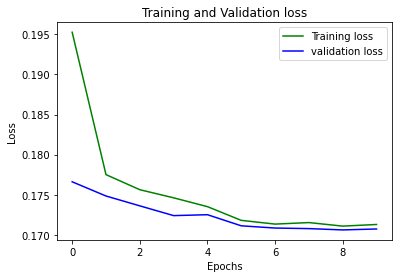

In [11]:
loss_train = train_epochs_loss['Loss']
loss_val = val_epochs_loss['Loss']
epochs = val_epochs_loss['Epoch No']
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [12]:
def eval_model(model, dataloader):
    """
    :return:
        Y_pred: prediction of model on the dataloder.
            Should be an 2D numpy float array where the second dimension has length 2.
        Y_test: truth labels. Should be an numpy array of ints
    TODO:
        evaluate the model using on the data in the dataloder.
        Add all the prediction and truth to the corresponding list
        Convert Y_pred and Y_test to numpy arrays (of shape (n_data_points, 2))
    """
    model.eval()
    #Y_pred = []
    #Y_test = []
    pred_df = pd.DataFrame(columns=["Image Index"])
    true_df = pd.DataFrame(columns=["Image Index"])
    #for data, target in dataloader:
    for i, data in enumerate(dataloader):
        # your code here
        inputs = data[0].to(device)
        labels = data[1].to(device)
        #inputs, labels, _ = data
        true_labels = labels.cpu().data.numpy()
        batch_size = true_labels.shape
        #print("batch_size : " , batch_size)
        y_hat = model(inputs)
        probs = y_hat.cpu().data.numpy()
        #y_hat = model(data)
        #y_hat_ = torch.max(y_hat,dim=1)
        #_, predicted = torch.max(y_hat, 1)
        #print(type(y_hat),y_hat)
        #print("predicted : " ,type(predicted),predicted.shape)
        #print("target : " ,target)
        #Y_pred.append(predicted.detach().numpy())
        #Y_test.append(target.detach().numpy())
        for j in range(0, batch_size[0]):
            thisrow = {}
            truerow = {}
            thisrow["Image Index"] = val_dataset.df.index[BATCH_SIZE * i + j]
            truerow["Image Index"] = val_dataset.df.index[BATCH_SIZE * i + j]

            # iterate over each entry in prediction vector; each corresponds to
            # individual label
            for k in range(len(val_dataset.PRED_LABEL)):
                thisrow["prob_" + val_dataset.PRED_LABEL[k]] = probs[j, k]
                truerow[val_dataset.PRED_LABEL[k]] = true_labels[j, k]

            pred_df = pred_df.append(thisrow, ignore_index=True)
            true_df = true_df.append(truerow, ignore_index=True)

        if(i % 10 == 0):
            print(str(i * BATCH_SIZE))

    #print()
        #raise NotImplementedError
    #Y_pred = np.concatenate(Y_pred, axis=0)
    #Y_test = np.concatenate(Y_test, axis=0)

    return pred_df, true_df

In [13]:
pred_df, true_df = eval_model(model, val_loader)

0
320
640
960
1280
1600
1920
2240


In [14]:
auc_df = pd.DataFrame(columns=["label", "auc"])

for column in true_df:
    #print('---------------------')
    #print("Column : " , column)
    if column not in [
            'Atelectasis',
            'Cardiomegaly',
            'Effusion',
            'Infiltration',
            'Mass',
            'Nodule',
            'Pneumonia',
            'Pneumothorax',
            'Consolidation',
            'Edema',
            'Emphysema',
            'Fibrosis',
            'Pleural_Thickening',
                'Hernia']:
        continue
    actual = true_df[column]
    #print( 'Actual : ' , actual)
    pred = pred_df["prob_" + column]
    #print('Pred : ' , pred)
    thisrow = {}
    thisrow['label'] = column
    thisrow['auc'] = np.nan
    try:
        thisrow['auc'] = sklm.roc_auc_score(
        actual.values.astype(int), pred.values)
        #auc_df = auc_df.append(thisrow, ignore_index=True)
    #except Exception:
        
    except BaseException as e:
        print("can't calculate auc for " + str(column))
        print(e)
    auc_df = auc_df.append(thisrow, ignore_index=True)

pred_df.to_csv("DenseNetpredsSGDMomentum.csv", index=False)
auc_df.to_csv("DenseNetaucsSGDMomentum.csv", index=False)